In [2]:
# Importing Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns
import thinkstats2, thinkplot


<H1>EDA and Regression</h1>

Here we will walk through doing a regression for a common example dataset, complete with walking through some common exploratory steps. This is representative of what we'd do in a real situation, just a simple version. As we go through this we want to:

<ul>
<li>Load and clean the data - make sure we've gotten rid of junk, fixed errors and blanks, corrected data type issues, etc...
<li>Explore the data - what does our data look like? Do we have consistent data? What are the distributions and correlations? Is there anything that may make us adjust or correct before proceeding?
<li>Shape the data for prediction - prep whatever data we are going to use in a regression ready format.
<li>Perform regression.
<li>Examine results
</ul>

For the cleaning and exploring steps especially, we aren't really following a specific set of actions. We want to look at the data, and see if there's anything to change - some data may need cleaning, some won't; some data may have features we want to remove or change, some won't. We basically just want to look for anything that might lead us to adjust our approach away from just using all the data unchanged - this example isn't super dirty/complex, so we won't be doing an overwhelming amount of action here. This process is something we get better at with time, practice, and more ML tools. 

In [3]:
# Importing the Dataset
df = pd.read_csv("data/auto-mpg.data",delim_whitespace=True, names=["MPG","Cylinders","Displacement","HP","Weight","Acceleration","Year","Origin","Name"])
df.head()

,MPG,Cylinders,Displacement,HP,Weight,Acceleration,Year,Origin,Name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [4]:
#Get some info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   HP            398 non-null    object 
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Year          398 non-null    int64  
 7   Origin        398 non-null    int64  
 8   Name          398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


I'll set the two categorical values as categorical. This isn't required, but it will tell some things (e.g. pairplot, describe) to treat it as a categorical variable. 

Having correctly identified datatypes may or may not make a difference in terms of whether or not things will work, but it is good practice and will make some functions work more as we'd expect. 

In [5]:
# Converting the variables to the correct types

#We'll need this once we notice the error below
df = df[df["HP"]!="?"]

df['Cylinders']=df['Cylinders'].astype('category')
df['Origin']=df['Origin'].astype('category')
df['HP']=df['HP'].astype('float64')
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   MPG           392 non-null    float64 
 1   Cylinders     392 non-null    category
 2   Displacement  392 non-null    float64 
 3   HP            392 non-null    float64 
 4   Weight        392 non-null    float64 
 5   Acceleration  392 non-null    float64 
 6   Year          392 non-null    int64   
 7   Origin        392 non-null    category
 8   Name          392 non-null    object  
dtypes: category(2), float64(5), int64(1), object(1)
memory usage: 25.6+ KB


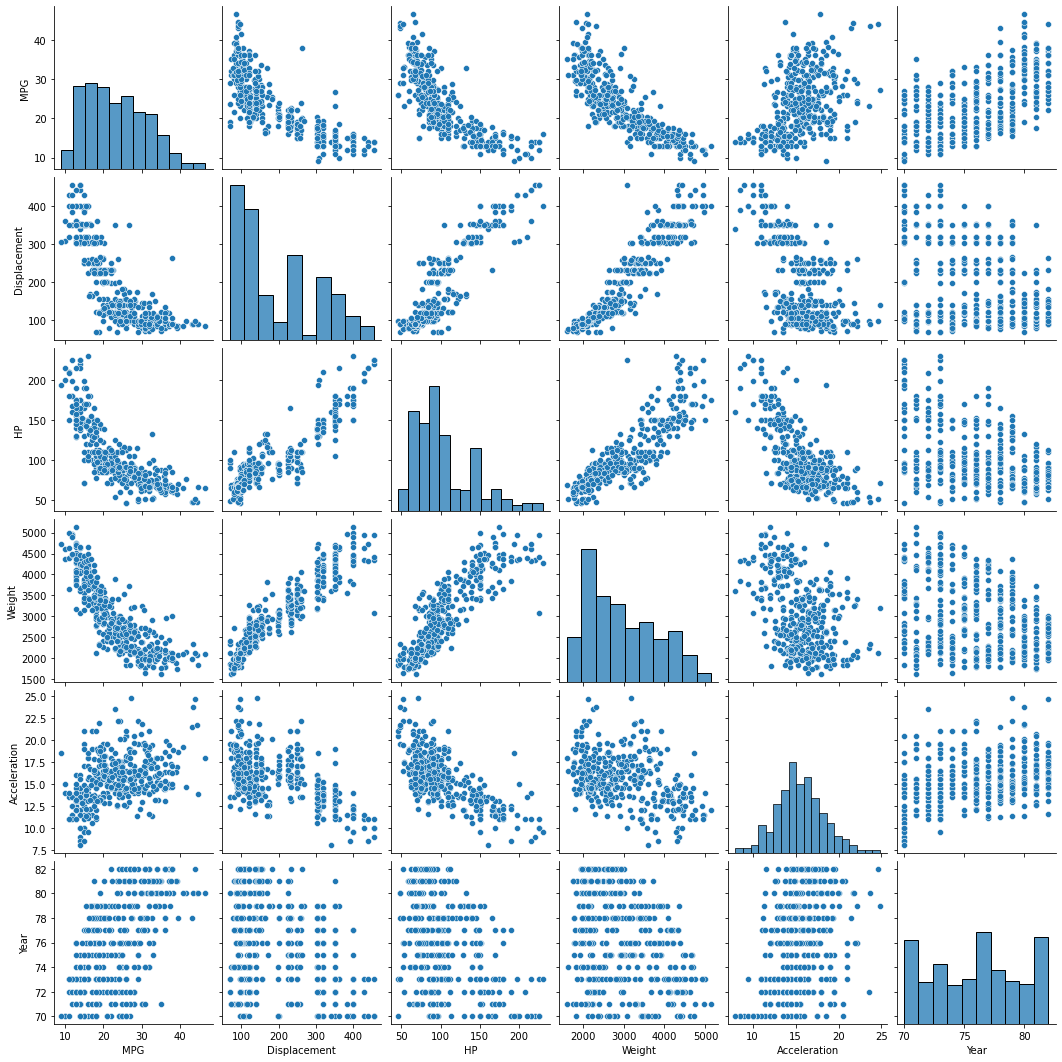

In [6]:
#visualize pairplot
sns.pairplot(df)

There are only a few things that we might need to be attentive of in the pairplot. For the most part the data looks unremarkable:
<ul>
<li>Some colinearity between weight, displacement, and HP. We can address that later on. 
<li>MPG (the target) looks to have a non-linear relationship with those varaibles. We'll consider things like that next time. 
</ul> 

## Categorical Features

We can look at boxplots and counts for the categorical varaibles. the countplot is basically just a simple hist for categorical data. 

We didn't know exactly what Origin was, but now I am going to suspect that it is American/Japanesse/European - we could likely verify this by looking at the data and using our domain knowledge of where different cars are from. 

The grid used below is the matplotlib way to do subplots, it is a sightly more elaborate version of the thinkplot one. We basically make a grid, then assign each graph to a square in the grid. The details of exactly how we visualize data don't really matter, as long as we graph it, but playing with some different ways gives us more tools to make things look OK. Googling "seaborn ___________" will almost always give some examples online - the seaborn stuff is much easier to use than the matplotlib directly, so I'd advise sticking to that. 

<AxesSubplot:xlabel='Origin', ylabel='count'>

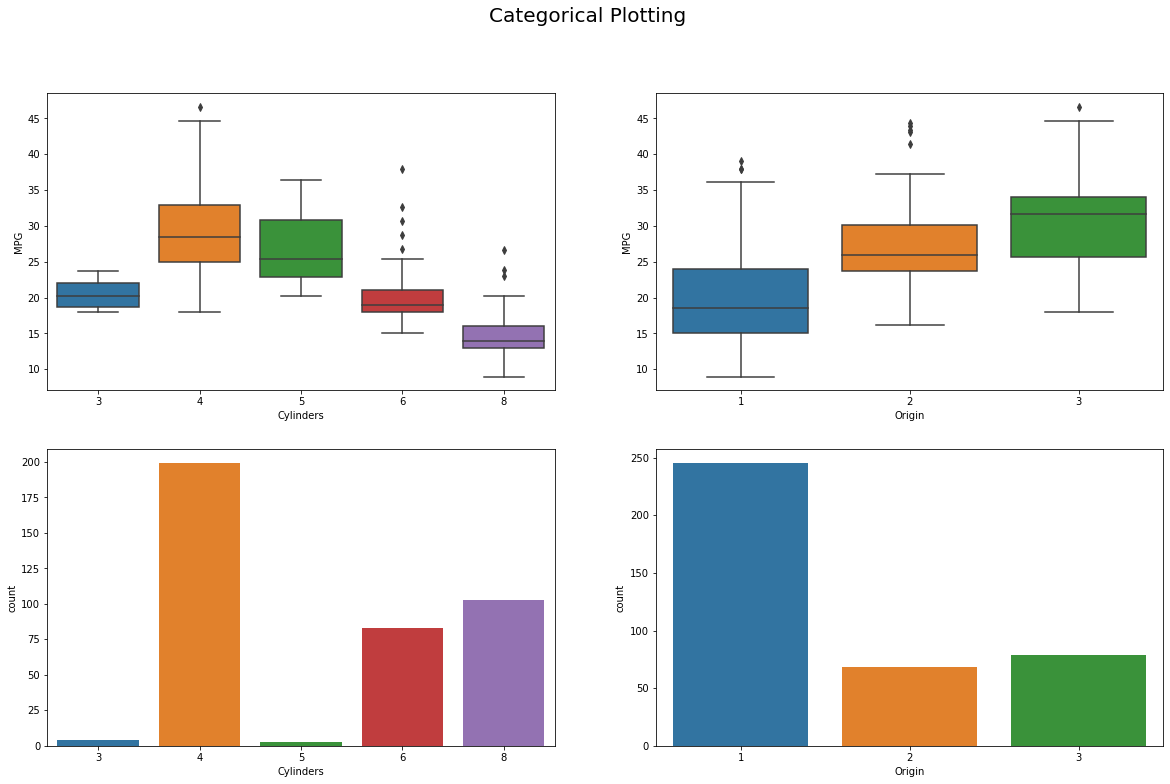

In [7]:
#Print boxplots - we'll put them in subplots to make it look fancy
#Countplots are basically categorical hists - we could've used a hist as well
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(20,12))
fig.suptitle("Categorical Plotting", fontsize=20)
sns.boxplot(x="Cylinders", y="MPG", data=df,ax=ax[0,0])
sns.boxplot(x="Origin", y="MPG", data=df,ax=ax[0,1])
sns.countplot(x="Cylinders", data=df,ax=ax[1,0])
sns.countplot(x="Origin", data=df,ax=ax[1,1])

In [8]:
df[df["Cylinders"]==3].Name.count(), df[df["Cylinders"]==5].Name.count()

(4, 3)

Looks like 3 and 5 cylinders are rare (if you konw about cars, this makes sense). I'm going to consider dropping those - we'll see. The reasoning is that we want to predict the MPG in general, there simply aren't very many samples for those two subgroups, so it may end up being more confounding than helpful. E.g. the impact of having 5 cylinders will be due to the 3 specific cars we have in the data, not the general impact of having that many cylinders. 

A similar example, say you were prediciting height of people and one factor was hair color. If you had 3 redheads in the data, any influence "being a redhead" has on the expected height would be overwhelmed by the influence that those specific 3 have. So that feature isn't giving you the "impact of having red hair" it is giving you the impact of "being Jim" - or the specific person in the sample. 

As well, if the data is being split, the results will probably be skewed - e.g. you may only get one 3 cylinder car in training the model - then the impact of 3 cylinders doesn't exist, you only get that one car. If you happen to get the one 3cyl car with terrible MPG, that will impact the results. If you got the most efficient 3cyl car ever in the next trial, things could then be totally different - the model would be unstable - bad. 

In [9]:
## Correlation Matrix
corr = df.corr()
corr.style.background_gradient()
corr.style.background_gradient().set_precision(2)

/var/folders/px/vhm_920n7zx2wvqq_ht0q5tm0000gp/T/ipykernel_57587/527883699.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient().set_precision(2)


,MPG,Displacement,HP,Weight,Acceleration,Year
MPG,1.00,-0.81,-0.78,-0.83,0.42,0.58
Displacement,-0.81,1.00,0.90,0.93,-0.54,-0.37
HP,-0.78,0.90,1.00,0.86,-0.69,-0.42
Weight,-0.83,0.93,0.86,1.00,-0.42,-0.31
Acceleration,0.42,-0.54,-0.69,-0.42,1.00,0.29
Year,0.58,-0.37,-0.42,-0.31,0.29,1.00


The correlation matrix is very useful in Linear Regression. We know that if there is correlation between the varibles then we can't accurately attribute the impact between the correlated variables. 

Here, weight and displacement (the size of the engine) are highly correlated. We may remove one later on... 
<br><br><br>

<h2>Prep data for regression</h2>

At this point we are pretty much ready to get our regression on. We just need to get the data in the right format. This will vary a little depending on what we want to use. We can also make some data cleaning choices relating to the issues we noticed above. 

In [10]:
#Clean out questionable bits - cylinders and correlated values. 
#We can try once with this and once without. 
#In this data, the difference probably won't be huge. 
print(len(df))
df_ = df.drop(columns={"Displacement","Name"})
df_ = df_[df_["Cylinders"]!=3]
df_ = df_[df_["Cylinders"]!=5]

#We need to remove the categories that are not used anymore.
#They don't automatically vanish. 
#The function from pandas need a series, so we have to do a roundabout way
df_['Cylinders'] = pd.Series(df_['Cylinders']).cat.remove_unused_categories()
print(len(df_))

392
385


In [11]:
#Check the cylinders 
df_["Cylinders"].value_counts()

4    199
8    103
6     83
Name: Cylinders, dtype: int64

## Categorical Dummies

We have two categorical variables - cylinders and origin. Currently it will work with the numbers, but I don't think it is best. Right now they'll be treated as numbers in the regression, and that doesn't make a tonne of sense; treating the country a car is from as a number in a linear regression is obviously silly.

Categorical varaibles are often very useful and contain a lot of information that we can use to make our models, however categorical data - either in it's original text format, or when represented (encoded) with a number here doesn't really work all that well with the math of regressions. So what do we do? 

### Encoding 

To deal with them better, we can use encoding to translate each categorical value into a (or a set of) numerical value. Once things are numerical, we can treat them as we do any of our other variables and use them as features. Since they are now numbers, we can "do math with them", so they can =be inputs (X's) for our linear regression. 

The idea of encoding is simple, rather than represent a categorical value with text, we represent it with a number. There are several methods that can be used to encode categorical data as numeric, and we will explore more when we look at data pipelines in machine learning. One method has actually been done already in our data - label encoding for the origin value - but we need to disect things a bit more to make sense of it. 

##### Categorical Data Types

When performing encoding, one thing to consider is what type of categorical data we have, specifically if our data has some implied order in its categories. We can split categorical data into two basic subsets:
<ul>
<li> <b>Ordinal Data:</b> the data has some ranking or ordering in its categories. 
    <ul>
    <li> E.g. shirt sizes (s,m,l,xl), a likert scale (class evaluation), or scholastic acheivement (high school, some university, degree, masters, doctorate).
    </ul>
<li> <b>Nominal Data:</b> the data doesn't have any implied order. 
    <ul>
    <li> E.g. hair color, home type (condo, duplex, house), or nationality. 
    </ul>
</ul>

#### Label Encoding / Ordinal Encoding

If we have data that does have some order, ideally with a uniform spacing of the values, ordinal encoding may make sense. This encoding just labels the items in order, e.g.:
<ul>
<li> Strongly disagree -> 1
<li> Disagree -> 2
<li> Agree -> 3
<li> Strongly agreee -> 4
</ul>

The idea here is that the numeric labels we apply reflect the actual order in the data, so we are hopefully capturing that "ranking" as an input to our model. 

<b>Note:</b> Label encoding is just this, but when there isn't an underlying order in the data. That's what we see with the country of origin with our data. 

#### One-Hot Encoding

Probably the most common type of encoding that we will use is called one-hot. One hot transforms the data by making each value in each categorical feature into it's own feature, marking a 1 in the one that is true, and a zero in the rest. This is easiest to see in an image: 

![One Hot](images/one_hot.png "One Hot")

This allows us to represent the categories numerically without generating any implication of ordering. On the downside, this generates data that is much wider, with more features - for small examples such as ours that is not really a concern, but if there are lots of categorical features which have lots of different values, some front end reduction in that data may be needed. This is another glance ahead, but we can end up more prone to poor models (overfitted - a term you'll grow to love), if the data is extremely wide. 

### Which Encoding to Use

The true answer is to try some and see what works best, and we will look at setting up those trials later on in the machine learning stuff. In general, the one-hot encoding is a good default.  

In [12]:
#Get some new info
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 385 entries, 0 to 397
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   MPG           385 non-null    float64 
 1   Cylinders     385 non-null    category
 2   HP            385 non-null    float64 
 3   Weight        385 non-null    float64 
 4   Acceleration  385 non-null    float64 
 5   Year          385 non-null    int64   
 6   Origin        385 non-null    category
dtypes: category(2), float64(4), int64(1)
memory usage: 19.1 KB


##### Dumb Pandas

Pandas has a function that can one-hot transform our data for us. 

In [13]:
# Do the dummies
df_tmp = pd.get_dummies(df_)
df_tmp.head(5)


,MPG,HP,Weight,Acceleration,Year,Cylinders_4,Cylinders_6,Cylinders_8,Origin_1,Origin_2,Origin_3
0,18.0,130.0,3504.0,12.0,70,0,0,1,1,0,0
1,15.0,165.0,3693.0,11.5,70,0,0,1,1,0,0
2,18.0,150.0,3436.0,11.0,70,0,0,1,1,0,0
3,16.0,150.0,3433.0,12.0,70,0,0,1,1,0,0
4,17.0,140.0,3449.0,10.5,70,0,0,1,1,0,0


Pretty simple, instead of each categorical column having several possible values, now each of those values is a column, and each row is true (or 1) in one of the columns and a false (or 0) for the others. 
<br>

<b>Drop the First</b>

The one issue here is that what is represented if all the columns are 0? <b>By giving each value its own column, we've invented possible data that doesn't exist in our original data - all 0s, or "none of the above."</b> The solution to this is to just drop a column for each category - that one that is dropped is represented by all 0s now. By doing this we avoid inventing some data. This is common, though not universal. For linear regression we want to get rid of that. 

<b>Note:</b> will this make a massive difference? Probably not. 

In [14]:
#Redo the dummy variables. 
df2 = pd.get_dummies(df_, drop_first=True)
df2.head(5)


,MPG,HP,Weight,Acceleration,Year,Cylinders_6,Cylinders_8,Origin_2,Origin_3
0,18.0,130.0,3504.0,12.0,70,0,1,0,0
1,15.0,165.0,3693.0,11.5,70,0,1,0,0
2,18.0,150.0,3436.0,11.0,70,0,1,0,0
3,16.0,150.0,3433.0,12.0,70,0,1,0,0
4,17.0,140.0,3449.0,10.5,70,0,1,0,0


The pandas function of creating the dummy variables is the most simplest one. The encoding notebook has an example of the sklearn process, but this way is much more simple. 

Next we want to split our features (Xs) and our target (Y). 

In [15]:
#X values in a DF
dfX = df2.drop(columns={"MPG"})
dfY = df2["MPG"]

#If we want an array for sklearn
y = np.array(dfY).reshape(-1,1)
x = np.array(dfX)
x.shape, y.shape


((385, 8), (385, 1))

#### Train Model

Data is ready to go - we can now either sklearn with the arrays or statsmodel with the dataframes or the arrays. 

We can split the data again into a training set and a test set, so we can calculate our accuracy on some new data. 

**Note: repeating the split/train/test/calculate cycle is often a good idea. We don't need to build a big loop (though we could) - we'll add this later on with a function built into sklearn that makes it easier** 

In [16]:
# Dividing the Dataset into Test and Train
# This does the splitting of both the xs and ys, and spits back all 4 sets. 
# This function is really common, and does the same thing as the sample splitting we did by hand
from sklearn.model_selection import train_test_split
xTrain,xTest,yTrain,yTest = train_test_split(x,y,test_size=.3)
print("X-Train:", xTrain.shape)
print("X-Test:", xTest.shape)
print("Y-Train:", yTrain.shape)
print("Y-Test:", yTest.shape)


X-Train: (269, 8)
X-Test: (116, 8)
Y-Train: (269, 1)
Y-Test: (116, 1)


In [17]:
# Implementing Linear Regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(xTrain,yTrain)


LinearRegression()

In [18]:
# Predictiions for TEST
# Calculate RMSE
ypred = model.predict(xTest)
mean_squared_error(ypred,yTest,squared=False)


3.0369063216348238

In [19]:
#Get Residuals and picture them in a DF for easy reading. 
tmp1 = pd.DataFrame(yTest, columns={"Y values"})
tmp2 = pd.DataFrame(ypred, columns={"Predictions"})
tmp3 = pd.DataFrame((yTest-ypred), columns={"Residual"})
resFrame = pd.concat([tmp1,tmp2,tmp3], axis=1)
resFrame.sort_values("Residual").head()

,Y values,Predictions,Residual
102,23.9,30.226295,-6.326295
38,21.6,26.620471,-5.020471
27,20.0,24.996469,-4.996469
92,18.1,23.045021,-4.945021
24,17.6,22.469767,-4.869767


After we're done with all of this testing, what if we want to use the model to make predictions? We all just got jobs monitoring MPG of new cars, and we are way to lazy to measure all of them, so we want to make accurate predictions and go back to sleep. 

For the model we want to use, we'll train it with all the data. The splitting and testing gave us good estimates for accuracy, but using all the data to create the model will deliver the best results in general. What it won't do is give us those test scores to evaluate it, but if we've already decided to use it we should train a new model with all the data. In practice we'd probably compare the test scores that we got here with the scores we got using different algorithms, then we'd train the most accurate one with all data and use that. 

## Exercise - Predict BMI

Follow a similar process to predict BMI using the data below. We will have one categorical variables as a feature - Outcome. Also, try a transformation - turn the pregnancies feature into a categorical value measuring if someone has had a kid or not. If you're a keener, try to split it into 3 categories - 0 kids, 2 or less kids, more than 2 kids. 

In [20]:
#Load data
df_d = pd.read_csv("data/diabetes.csv")
df_d.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Non-Linear Relationships

Return of Anscombe... We can look at dataset 2, which is a pretty clear non-linear relationship. 

In [21]:
#Data
d2 = sns.load_dataset("anscombe")
d2 = d2[d2["dataset"]=="II"]
d2.head()

,dataset,x,y
11,II,10.0,9.14
12,II,8.0,8.14
13,II,13.0,8.74
14,II,9.0,8.77
15,II,11.0,9.26


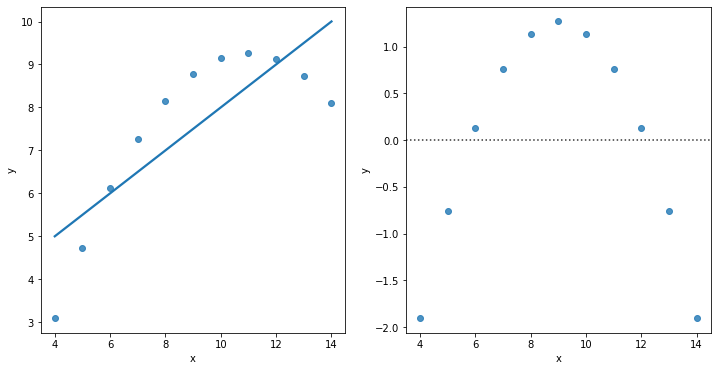

In [22]:
#Plot regresion and residuals
thinkplot.PrePlot(2,1,2)
sns.regplot(data=d2, x="x", y="y", ci=0)
thinkplot.SubPlot(2)
sns.residplot(data=d2, x="x", y="y")
thinkplot.Config()

In [23]:
#Regular regression
x = np.array(d2["x"]).reshape(-1,1)
y = np.array(d2["y"]).reshape(-1,1)

m1 = LinearRegression()
m1.fit(x,y)
m1Pred = m1.predict(x)

rmse = np.sqrt(mean_squared_error(y,m1Pred))
r2 = m1.score(x,y)
print(rmse)
print(r2)

1.1191023557497446
0.6662420337274844


<h3>Regression Results</h3>

We can plot it. We can perform a linear regression. It doesn't really look like the best choice though. Visually, the fit isn't great. Numerically, the R2 isn't really great. (The RMSE is probably bad as well, but it is hard to judge that without context.)

The residuals show a really distinct pattern - the data obviously forms a curve, and a linear regression is well... linear. Back when we started looking at residuals we noted that we don't want a pattern in the residuals because that is valuable info that we aren't capturing in our model. 

To 'capture' that stuff that we missed, we can make our model different - a curve that more accurately fits the data. 

### Pipelines

This is our first look at the pipeline feature, which will become very important and useful going forward. A pipeline helps up do a few things:
<ul>
<li> The pipeline object "takes the place" of our model for most actions that we call the model for - such as fit, score, and predict. 
<li> We make the pipeline by adding steps to it, the final step being the actual model. 
<li> The steps we add are mainly data preparation steps. We will cover lots of this stuff in the beginning of the machine learning course. 
<li> The end result is that we can provide data in its origninal form, and the pipeline can do all the prep stuff as it does the modelling stuff. 
</ul>

Here, we have one step prior to the modelling - the polynomial transformation. So our pipeline will take the data, do the polynomial thing, then fit the model as we're used to. The pipeline then "is" our model for all intents and puposes after that, so when we want to make predictions we call predict on the pipeline, and it'll go do all of its steps and give us predictions. 

In [24]:
#Non linear regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

poly = PolynomialFeatures(degree=2)
m2 = make_pipeline(poly, LinearRegression())
m2.fit(x,y)
ypred = m2.predict(x)

In [25]:
#Metrics
rmse = np.sqrt(mean_squared_error(y,ypred))
r2 = m2.score(x,y)
print(rmse)
print(r2) 

0.0014262991646425056
0.999999457857722


<h3>Boom - More accurate. </h3>

Note the residual plot - the distances don't look great, but the default scale is really zoomed in. The actual values are tiny. 

This will also lead into one of the important concepts of Machine Learning later on - overfitting and underfitting. We want a model that reflects our data - but not one so customized that it is not able to accurately predict new data. We want something that (more or less) cuts through the middle of the data without bouncing around to "connect the dots". This is important later on...

<AxesSubplot:xlabel='x', ylabel='y'>

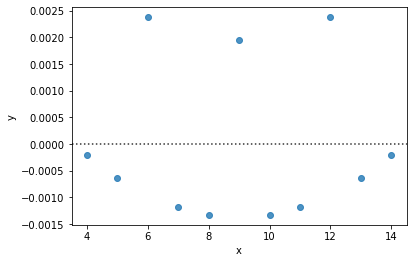

In [26]:
#Plot stuff

sns.residplot(data=d2, x="x", y="y", order=2)


<AxesSubplot:xlabel='x', ylabel='y'>

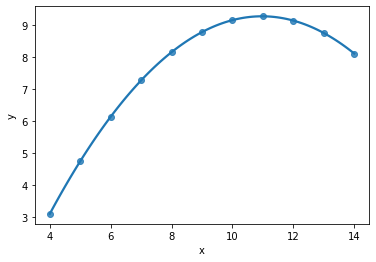

In [27]:
sns.regplot(data=d2, x="x", y="y", order=2)

## Exercise - Predict MPG from HP

In [28]:
df_poly = df[["MPG", "HP"]]
df_poly.head()

,MPG,HP
0,18.0,130.0
1,15.0,165.0
2,18.0,150.0
3,16.0,150.0
4,17.0,140.0
